In [1]:
import random as rd
from random import randint
import numpy as np, random, matplotlib.pyplot as plt
import time

In [2]:
class Item:
    def __init__(self, weight, value):
        self.weight = int(weight)
        self.value = int(value)

    def worthiness(self, item):
        return item.value/item.weight

In [3]:
class Fitness:
    def __init__(self, bag, Items, maxCap):
        self.bag = bag
        self.Items = Items
        self.maxCapacity = int(maxCap)
        self.fitness = 0

    # Calculate the fitness of individuals
    def bagFitness(self):
        values = [x.value for x in self.Items]
        weights = [x.weight for x in self.Items]
        totalVal = np.sum(self.bag * values)
        totalWeight = np.sum(self.bag * weights)
        if totalWeight <= self.maxCapacity:
            self.fitness = totalVal
        else:
            self.fitness = 0
        return self.fitness

In [4]:
NumOfItems = None
weightOfKnapsack = None

# Read the data from the file
def read_data(filename):
    with open(filename) as f:
        Items = f.readlines()
        return Items

# Return all of the items in the file in a suitable format
def all_items(items):
    all_item = []
    for i in items:
        items_info = i.rsplit()
        item = Item(items_info[1], items_info[0])
        all_item.append(item)
    return all_item

Functions for Creating our First Generations

In [5]:
# Create the first population
def initialPopulation(popSize, numOfItems):
    all_initial_population = []
    for i in range(popSize):
        initial_population = np.zeros((numOfItems, ))
        randNum = np.random.randint(0, NumOfItems-1, 1)
        initial_population[randNum] = 1
        initial_population = initial_population.astype(int)
        all_initial_population.append(initial_population)
    return np.array(all_initial_population)

Function for calculating fitness of the population

In [6]:
# Calculate Fitness of the population
def popFitness(population, items):
    fitnessResults = np.empty(len(population))
    for i in range(len(population)):
        fitnessResults[i] = Fitness(population[i],items, weightOfKnapsack).bagFitness()
    return fitnessResults.astype(int)

In [7]:
# Select the remaining individuals
def selection(fit, remainingSize):
    fitness = list(fit)
    length = len(fit) - remainingSize
    selectionResults = np.zeros((len(fit), ))
    for i in range(remainingSize):
        selectionResults[i] = fit[i]
        fitness[i] = -999999

    for i in range(length):
        max_fitness_idx = np.where(fit == np.max(fitness))
        selectionResults[i] = int(max_fitness_idx[0][0])
        fitness[max_fitness_idx[0][0]] = -999999
    return selectionResults

In [8]:
# Selecting the parents of the next Generation
def matingPool(population, selectionResults):
    matingpool = []
    # print(len(selectionResults))
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[int(index)])
    return matingpool

In [9]:
# Create a crossover function for two parents to create one child
def crossOver(parent1, parent2, items, crossover_rate):
    offspring = np.empty(len(parent2))
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    fit_par1 = Fitness(parent1, items, weightOfKnapsack).bagFitness()
    fit_par2 = Fitness(parent2, items, weightOfKnapsack).bagFitness()
    if fit_par1 > fit_par2:
        stronger_parent = parent1
        weaker_parent = parent2

    else:
        stronger_parent = parent2
        weaker_parent = parent1

    x = rd.random()
    if x < crossover_rate:
        offspring[startGene:endGene] = stronger_parent[startGene:endGene]
        offspring[endGene:] = weaker_parent[endGene:]
        offspring[:startGene] = weaker_parent[:startGene]

    elif x == crossover_rate:
        offspring = stronger_parent

    else:
        offspring = weaker_parent

    return offspring

In [10]:
# Create function to run crossover over all of population pair
def crossoverPopulation(matingpool, remainingSize, items, crossover_rate):
    children = []
    length = len(matingpool) - remainingSize

    pool = random.sample(matingpool, len(matingpool))

    for i in range(0, remainingSize):
        children.append(matingpool[i])

    for i in range(0, length):
        i = np.random.randint(0, len(children))
        child = crossOver(pool[i], pool[len(matingpool) - i - 1], items, crossover_rate)
        children.append(child)
    return np.array(children).astype(int)

In [11]:
# Create mutation over all of our population
def mutatePopulation(population, mutationRate):
    mutants = [x for x in population]
    for i in range(len(population)):
        random_value = rd.random()
        if random_value > mutationRate:
            continue
        int_random_value = randint(0,len(population[i])-1)
        if mutants[i][int_random_value] == 0 :
            mutants[i][int_random_value] = 1
        else :
            mutants[i][int_random_value] = 0
    return mutants

In [12]:
# Create the next generation by pulling all steps together
def nextGeneration(currentGen, remainingSize, mutationRate, crossover_rate, items):
    popRanked = popFitness(currentGen, items)
    selectionResults = selection(popRanked, remainingSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = crossoverPopulation(matingpool, remainingSize, items, crossover_rate)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

In [13]:
# Final step: create the genetic algorithm
def geneticAlgorithm(items, popSize, remainingSize, mutationRate, crossover_rate, generations, plot=True):
    pop = initialPopulation(popSize, len(items))
    maxValHist = []
    sum_fit = []
    values = np.array(pop) * [x.value for x in items]
    weights = np.array(pop) * [x.weight for x in items]

    for f in popFitness(pop, items):
        sum_fit.append(np.sum(f))
    maxValHist.append(np.max(sum_fit))

    max_weight = 0
    for v in range(len(values)):
        if np.sum(values[v]) == maxValHist[0]:
            max_weight = np.sum(weights[v])
            break

    print("Initial Value: " + str(maxValHist[0])+ ", Initial Weight: " + str(max_weight))

    for i in range(0, generations):
        pop = nextGeneration(pop, remainingSize, mutationRate, crossover_rate, items)
        if plot:
            sum_fit = []
            for j in popFitness(pop, items):
                sum_fit.append(np.sum(j))
            maxValHist.append(np.max(sum_fit))

    fitness_last_gen = popFitness(pop, items)
    max_value = np.max(fitness_last_gen)
    values = np.array(pop) * [x.value for x in items]
    weights = np.array(pop) * [x.weight for x in items]
    max_weight = 0
    for v in range(len(values)):
        if np.sum(values[v]) == max_value:
            max_weight = np.sum(weights[v])
            break

    print("Max value is : " + str(max_value) + " and knapsack weight is : " + str(max_weight))
    if plot:
        plt.plot(maxValHist, color='blue', linestyle='dotted')
        plt.ylabel('MaxValue')
        plt.xlabel('Generation')
        plt.show()
    return max_value

Initial Value: 997, Initial Weight: 199


Max value is : 8759 and knapsack weight is : 970


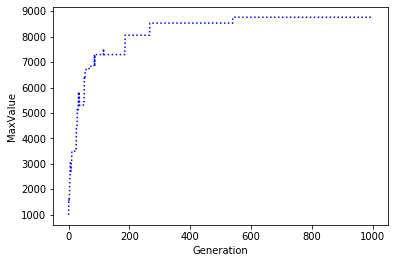

elapsed time is:  0.5686287403106689 min


In [19]:
if __name__ == '__main__':
    start = time.time()
        
    readItems = read_data('knapsack_1.txt')
    info = readItems[0].rsplit()
    NumOfItems = int(info[0])
    weightOfKnapsack = int(info[1])
    item_list = all_items(readItems[1:])
    geneticAlgorithm(items=item_list, popSize=100, remainingSize=25, mutationRate=0.4,crossover_rate=0.8, generations=1000)
    
    end = time.time()
    print('elapsed time is: ', (end-start)/60.0, 'min')